<p><img height="80px" src="https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/UPM/Escudo/EscUpm.jpg" align="left" hspace="0px" vspace="0px"></p>

**Universidad Politécnica de Madrid (UPM)**

# **S3: Robótica y Percepción** - Modelos profundos para visión por computador



### **1. Breve descripción del objetivo del trabajo**

El objetivo de este trabajo es comparar distintas arquitecturas de redes neuronales profundas aplicadas a la tarea de clasificación de imágenes en el conjunto de datos **CIFAR-100**, que contiene 100 clases de objetos naturales en imágenes de baja resolución (32x32 píxeles).

Las **arquitecturas evaluadas** son:

- Una red **fully-connected (ffNN)** simple, que ignora la estructura espacial de las imágenes.
- Una **CNN básica**, diseñada desde cero, compuesta por capas convolucionales, de pooling y densas.
- Una red **preentrenada ResNet-50**, con pesos aprendidos sobre ImageNet, adaptada a CIFAR-100.
- Una red **preentrenada MobileNetV2**, optimizada para entornos con recursos limitados.

Todas las arquitecturas se entrenaron bajo condiciones similares y fueron evaluadas con métricas relevantes como **accuracy**, **matriz de confusión**, **precisión**, **recall**, **F1-score**, **tiempo de entrenamiento** y **número total de parámetros**.

El experimento se llevó a cabo usando **TensorFlow/Keras**, ejecutado en **Google Colab con GPU gratuita (NVIDIA T4)**, con un enfoque práctico que equilibra rendimiento y eficiencia computacional.

## **2. Preparación del dataset**

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import math

# Cargar CIFAR-100
(x_train, y_train), (x_valid, y_valid) = tf.keras.datasets.cifar100.load_data()
print(f'Train: {x_train.shape}, {y_train.shape}')
print(f'Validation: {x_valid.shape}, {y_valid.shape}')

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
Train: (50000, 32, 32, 3), (50000, 1)
Validation: (10000, 32, 32, 3), (10000, 1)


#### **Preprocesamiento**: resize a 224x224 y normalización

Ya que la red ResNet-50 requiere imágenes de 224x224, aplicamos resize para todos los modelos para mantener coherencia.



In [ ]:
IMG_SIZE = 224
NUM_CLASSES = 100

def preprocess_image(image):
    # Resize y normalización a [0,1]
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image.astype(np.float32) / 255.0
    return image

#### **Generador de imágenes**
Reutilizamos el generador ya implementado, adaptado para CIFAR-100 (100 clases).

In [ ]:
def generator_images(objs, batch_size, do_shuffle=False):
    while True:
        if do_shuffle:
            np.random.shuffle(objs)
        groups = [objs[i:i + batch_size] for i in range(0, len(objs), batch_size)]
        for group in groups:
            images, labels = [], []
            for (image, label) in group:
                image = preprocess_image(image)
                images.append(image)
                labels.append(tf.keras.utils.to_categorical(label[0], num_classes=NUM_CLASSES))
            yield np.array(images), np.array(labels)

## **3. Callbacks y utilidades**

Callbacks para todos los modelos, incluyendo early stopping y reducción de tasa de aprendizaje.

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TerminateOnNaN

callbacks = [
    ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=10, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=20, verbose=1),
    TerminateOnNaN()
]

#### Funciones de métricas y visualización

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def draw_confusion_matrix(cm, class_names):
    plt.figure(figsize=(12,10))
    sns.heatmap(cm, cmap="viridis", cbar=True, xticklabels=False, yticklabels=False)
    plt.title("Matriz de Confusión")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


def compute_metrics(cm):
    correct_samples_class = np.diag(cm).astype(float)
    total_samples_class = np.sum(cm, axis=1).astype(float)
    total_predicts_class = np.sum(cm, axis=0).astype(float)

    accuracy = np.sum(correct_samples_class) / np.sum(total_samples_class)
    recall = correct_samples_class / np.maximum(total_samples_class, np.finfo(np.float64).eps)
    precision = correct_samples_class / np.maximum(total_predicts_class, np.finfo(np.float64).eps)
    f1 = 2 * (precision * recall) / np.maximum(precision + recall, np.finfo(np.float64).eps)

    return {
        "accuracy": accuracy * 100,
        "precision": np.mean(precision) * 100,
        "recall": np.mean(recall) * 100,
        "f1": np.mean(f1) * 100
    }

## 4. **MODELOS**

### **4.1. Fully Connected Neural Network (ffNN)**

Ya que aumentamos la complejidad del problema de 10 a 100 clases, aumentamos las capas de 10 a 512, y

In [ ]:
# Definición del modelo
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation

print('Definición del modelo ffNN')
ffnn_model = Sequential()
ffnn_model.add(Flatten(input_shape=(224, 224, 3)))
ffnn_model.add(Dense(512, activation='relu'))
ffnn_model.add(Dropout(0.2))
ffnn_model.add(Dense(NUM_CLASSES, activation='softmax'))  # NUM_CLASSES = 100
ffnn_model.summary()

Definición del modelo ffNN


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    77,070,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        51,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,122,148 (294.20 MB)

 Trainable params: 77,122,148 (294.20 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compilación
from keras.optimizers import Adam

ffnn_model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Entrenamiento del modelo
import time

epochs = 20
batch_size = 32
train_steps = math.ceil(len(y_train) / batch_size)
valid_steps = math.ceil(len(y_valid) / batch_size)

train_generator = generator_images(list(zip(x_train, y_train)), batch_size, do_shuffle=True)
valid_generator = generator_images(list(zip(x_valid, y_valid)), batch_size, do_shuffle=False)

print("Entrenando modelo ffNN...")
start_time = time.time()
ffnn_history = ffnn_model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    validation_data=valid_generator,
    validation_steps=valid_steps,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)
training_time_ffnn = time.time() - start_time
print(f"Tiempo total de entrenamiento: {training_time_ffnn:.2f} segundos")

Entrenando modelo ffNN...
Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.0094 - loss: 12.2074
Epoch 1: val_accuracy improved from -inf to 0.01000, saving model to best_model.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 58s 35ms/step - accuracy: 0.0094 - loss: 12.2034 - val_accuracy: 0.0100 - val_loss: 4.6052 - learning_rate: 0.0010
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.0103 - loss: 4.6062
Epoch 2: val_accuracy did not improve from 0.01000
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 45s 29ms/step - accuracy: 0.0103 - loss: 4.6062 - val_accuracy: 0.0100 - val_loss: 4.6052 - learning_rate: 0.0010
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.0097 - loss: 4.6056
Epoch 3: val_accuracy did not improve from 0.01000
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 53ms/step - accuracy: 0.0097 - loss: 4.6056 - val_accuracy: 0.0100 - val_loss: 4.6052 - learning_rate: 0.0010
Epoch 4/20
1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.0082 - loss: 

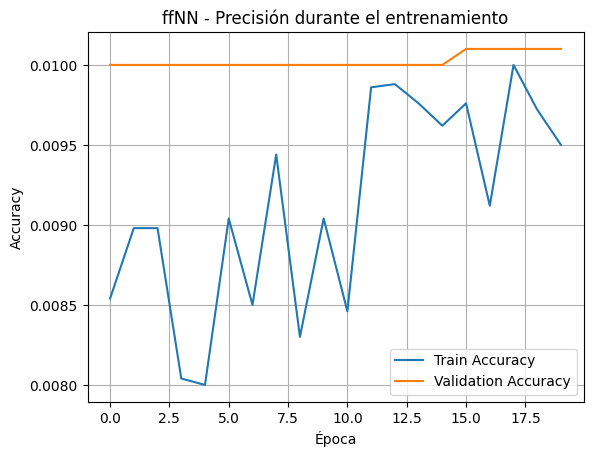

In [ ]:
# Accuracy por época
import matplotlib.pyplot as plt

plt.plot(ffnn_history.history['accuracy'], label='Train Accuracy')
plt.plot(ffnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.title('ffNN - Precisión durante el entrenamiento')
plt.legend()
plt.grid()
plt.show()

#### Evaluación

In [ ]:
# Predicción de etiquetas para el conjunto de validación
y_true, y_pred = [], []

for i in range(len(x_valid)):
    img = preprocess_image(x_valid[i])
    img = np.expand_dims(img, axis=0)
    pred = ffnn_model.predict(img, verbose=0)
    y_true.append(y_valid[i][0])
    y_pred.append(np.argmax(pred))

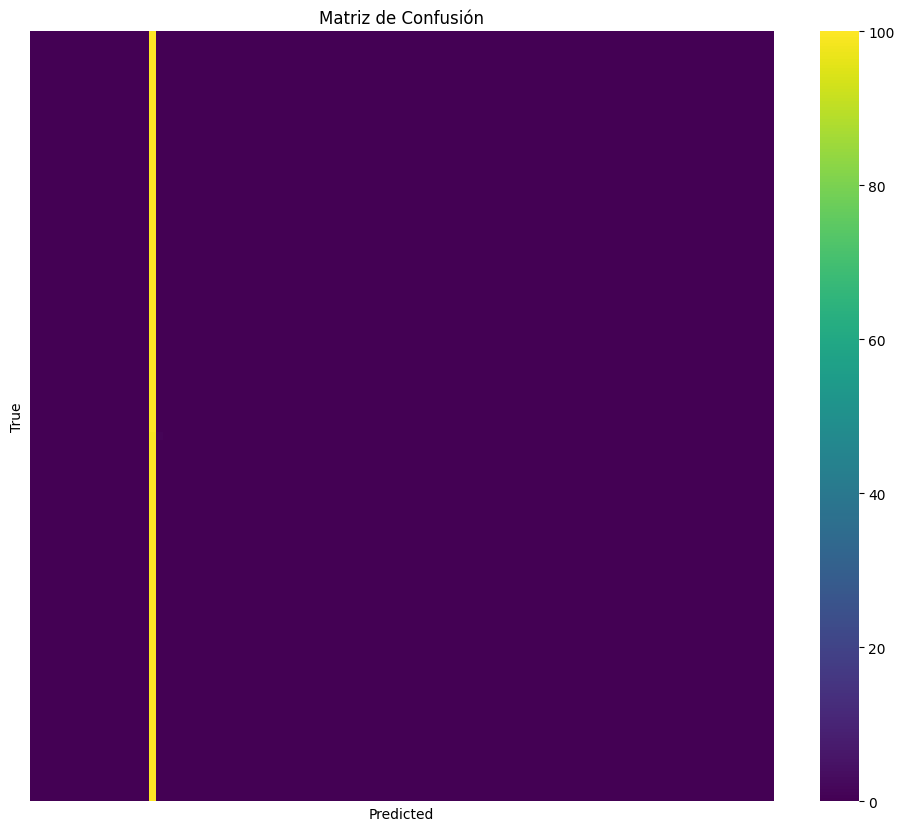

In [ ]:
# Matriz de confusión
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred, labels=range(NUM_CLASSES))

cifar100_labels = [str(i) for i in range(NUM_CLASSES)]
draw_confusion_matrix(cm, cifar100_labels)

In [ ]:
# Métricas
compute_metrics(cm)

{'accuracy': np.float64(1.0),
 'precision': np.float64(0.010001000100010001),
 'recall': np.float64(1.0),
 'f1': np.float64(0.01980394098425587)}

 ### **4.2. Convolutional Neural Network (CNN)**

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import BatchNormalization, Dropout, Dense, Activation

def build_cnn(input_shape=(224, 224, 3), num_classes=100):
    model = Sequential()

    # Bloque 1
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Bloque 2
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Bloque 3
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Global Average Pooling
    model.add(GlobalAveragePooling2D())

    # Clasificación
    model.add(Dropout(0.4))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))

    return model

cnn_model = build_cnn(input_shape=(224, 224, 3), num_classes=NUM_CLASSES)
cnn_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │        12,900 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,556 (482.64 KB)

 Trainable params: 123,108 (480.89 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
cnn_model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Entrenamiento
print("Entrenando nueva CNN...")
start_time = time.time()
cnn_history = cnn_model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    validation_data=valid_generator,
    validation_steps=valid_steps,
    epochs=20,
    callbacks=callbacks,
    verbose=1
)
training_time_cnn = time.time() - start_time
print(f"Tiempo total de entrenamiento: {training_time_cnn:.2f} segundos")

Entrenando nueva CNN...
Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.0428 - loss: 4.3702
Epoch 1: val_accuracy improved from 0.01010 to 0.07560, saving model to best_model.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 106s 61ms/step - accuracy: 0.0428 - loss: 4.3702 - val_accuracy: 0.0756 - val_loss: 3.9831 - learning_rate: 0.0010
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.0805 - loss: 3.9946
Epoch 2: val_accuracy did not improve from 0.07560
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 143s 91ms/step - accuracy: 0.0805 - loss: 3.9945 - val_accuracy: 0.0742 - val_loss: 4.0961 - learning_rate: 0.0010
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.0999 - loss: 3.8579
Epoch 3: val_accuracy improved from 0.07560 to 0.11720, saving model to best_model.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 139s 89ms/step - accuracy: 0.0999 - loss: 3.8579 - val_accuracy: 0.1172 - val_loss: 3.7937 - learning_rate: 0.0010
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 

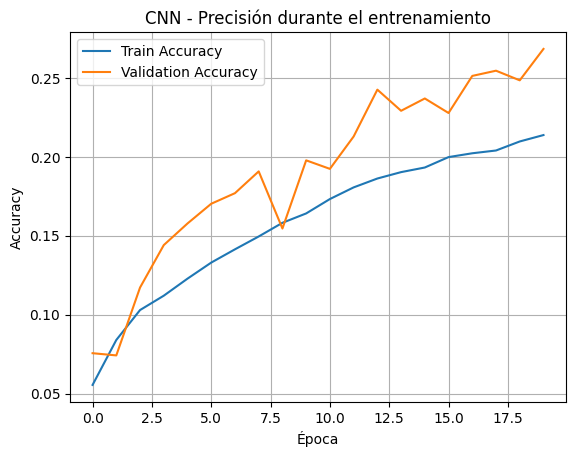

In [ ]:
# Accuracy por época

plt.plot(cnn_history.history['accuracy'], label='Train Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.title('CNN - Precisión durante el entrenamiento')
plt.legend()
plt.grid()
plt.show()

#### Evaluación

In [ ]:
# Predicción de etiquetas para el conjunto de validación
y_true_cnn, y_pred_cnn = [], []

for i in range(len(x_valid)):
    img = preprocess_image(x_valid[i])
    img = np.expand_dims(img, axis=0)
    pred = cnn_model.predict(img, verbose=0)
    y_true_cnn.append(y_valid[i][0])
    y_pred_cnn.append(np.argmax(pred))


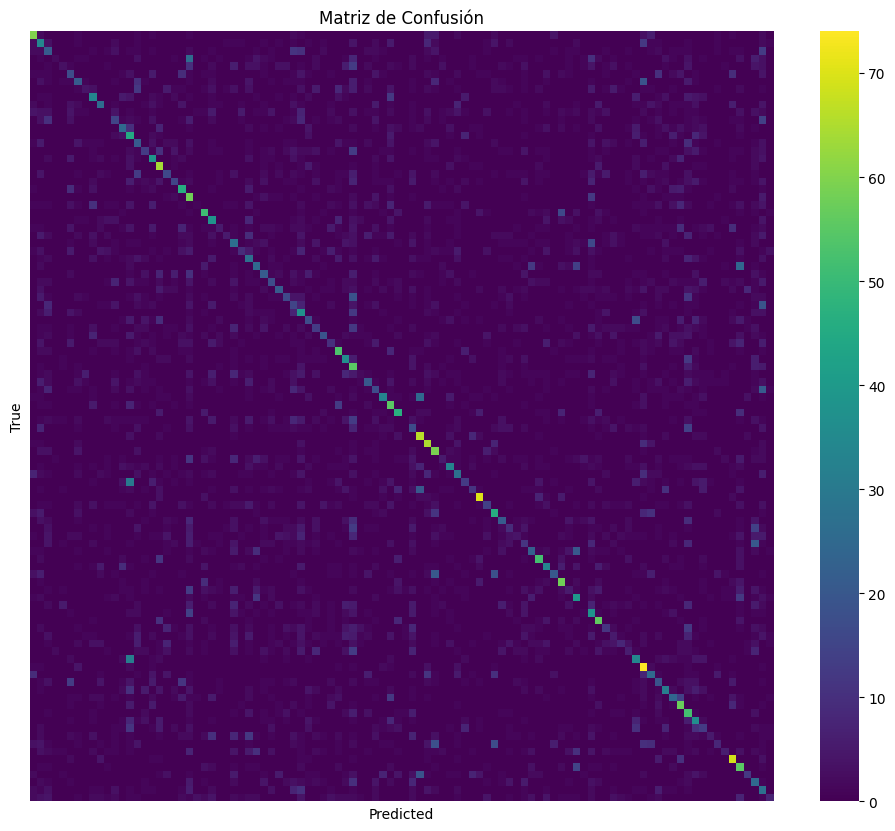

{'accuracy': np.float64(26.75),
 'precision': np.float64(26.811515214146663),
 'recall': np.float64(26.75),
 'f1': np.float64(24.310072649446486)}

In [ ]:
# Matriz de confusión
cm_cnn = confusion_matrix(y_true_cnn, y_pred_cnn, labels=range(NUM_CLASSES))
draw_confusion_matrix(cm_cnn, cifar100_labels)

# Métricas
compute_metrics(cm_cnn)

### **4.3. ResNet-50 preentrenada**

In [ ]:
# Cargar ResNet-50
from keras.applications import ResNet50
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from keras.applications.resnet50 import preprocess_input

# Nueva función de preprocesamiento (reemplaza preprocess_image si decides usarla solo para ResNet)
def preprocess_image_resnet(image):
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image.astype(np.float32)
    image = preprocess_input(image)  # propio de ResNet50
    return image

# Generador adaptado para ResNet
def generator_images_resnet(objs, batch_size, do_shuffle=False):
    while True:
        if do_shuffle:
            np.random.shuffle(objs)
        groups = [objs[i:i+batch_size] for i in range(0, len(objs), batch_size)]
        for group in groups:
            images, labels = [], []
            for (image, label) in group:
                image = preprocess_image_resnet(image)
                images.append(image)
                labels.append(tf.keras.utils.to_categorical(label[0], num_classes=NUM_CLASSES))
            yield np.array(images), np.array(labels)

In [ ]:
# Carga del modelo base preentrenado (sin top)
base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=Input(shape=(224, 224, 3)))

# Congelar todas las capas convolucionales
for layer in base_model.layers:
    layer.trainable = False

# Capa densa final
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

resnet_model = Model(inputs=base_model.input, outputs=predictions)
resnet_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,137,956 (92.08 MB)

 Trainable params: 550,244 (2.10 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# Compilación
resnet_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Entrenamiento
train_generator_resnet = generator_images_resnet(list(zip(x_train, y_train)), batch_size, do_shuffle=True)
valid_generator_resnet = generator_images_resnet(list(zip(x_valid, y_valid)), batch_size, do_shuffle=False)

print("Entrenando modelo ResNet-50 (capas congeladas)...")
start_time = time.time()
resnet_history = resnet_model.fit(
    train_generator_resnet,
    steps_per_epoch=train_steps,
    validation_data=valid_generator_resnet,
    validation_steps=valid_steps,
    epochs=10,
    callbacks=callbacks,
    verbose=1
)
training_time_resnet = time.time() - start_time
print(f"Tiempo total de entrenamiento: {training_time_resnet:.2f} segundos")

Entrenando modelo ResNet-50 (capas congeladas)...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_165']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.1025 - loss: 4.2417
Epoch 1: val_accuracy improved from 0.26840 to 0.55420, saving model to best_model.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 183s 108ms/step - accuracy: 0.1026 - loss: 4.2412 - val_accuracy: 0.5542 - val_loss: 1.7306 - learning_rate: 1.0000e-04
Epoch 2/10
1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.4278 - loss: 2.1805
Epoch 2: val_accuracy improved from 0.55420 to 0.63608, saving model to best_model.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 198s 127ms/step - accuracy: 0.4278 - loss: 2.1803 - val_accuracy: 0.6361 - val_loss: 1.3450 - learning_rate: 1.0000e-04
Epoch 3/10
1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.5153 - loss: 1.7634
Epoch 3: val_accuracy improved from 0.63608 to 0.66603, saving model to best_model.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 156s 100ms/step - accuracy: 0.5153 - loss: 1.7633 - val_accuracy: 0.6660 - val_loss: 1.2126 - learning_rate: 1.0000e-04
Epoch 4/10
1562/1563 ━━━

In [ ]:
# Accuracy por época
plt.plot(resnet_history.history['accuracy'], label='Train Accuracy')
plt.plot(resnet_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.title('ResNet-50 - Precisión durante el entrenamiento')
plt.legend()
plt.grid()
plt.show()

Evaluación

In [ ]:
# Predicción de etiquetas para el conjunto de validación
y_true_resnet, y_pred_resnet = [], []

for i in range(len(x_valid)):
    img = preprocess_image_resnet(x_valid[i])
    img = np.expand_dims(img, axis=0)
    pred = resnet_model.predict(img, verbose=0)
    y_true_resnet.append(y_valid[i][0])
    y_pred_resnet.append(np.argmax(pred))


In [ ]:
# Matriz de confusión
cm_resnet = confusion_matrix(y_true_resnet, y_pred_resnet, labels=range(NUM_CLASSES))
draw_confusion_matrix(cm_resnet, cifar100_labels)

In [ ]:
# Métricas por clase
compute_metrics(cm_resnet)

### **4.4. MobileNetV2 preentrenada**

In [ ]:
from keras.applications import MobileNetV2
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from keras.applications.mobilenet_v2 import preprocess_input

# Preprocesamiento específico de MobileNetV2
def preprocess_image_mobilenet(image):
    image = cv2.resize(image, (224, 224))
    image = image.astype(np.float32)
    return preprocess_input(image)

# Generador para MobileNetV2
def generator_images_mobilenet(objs, batch_size, do_shuffle=False):
    while True:
        if do_shuffle:
            np.random.shuffle(objs)
        groups = [objs[i:i+batch_size] for i in range(0, len(objs), batch_size)]
        for group in groups:
            images, labels = [], []
            for (image, label) in group:
                image = preprocess_image_mobilenet(image)
                images.append(image)
                labels.append(tf.keras.utils.to_categorical(label[0], num_classes=NUM_CLASSES))
            yield np.array(images), np.array(labels)

# Cargar MobileNetV2 con pesos preentrenados (ImageNet)
mobilenet_base = MobileNetV2(include_top=False, weights='imagenet', input_tensor=Input(shape=(224, 224, 3)))

# Congelar capas convolucionales
for layer in mobilenet_base.layers:
    layer.trainable = False

# Añadir capa final para clasificación en 100 clases
x = mobilenet_base.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

mobilenet_model = Model(inputs=mobilenet_base.input, outputs=predictions)
mobilenet_model.summary()

In [ ]:
# Compilación
mobilenet_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Entrenamiento
train_generator_mobilenet = generator_images_mobilenet(list(zip(x_train, y_train)), batch_size, do_shuffle=True)
valid_generator_mobilenet = generator_images_mobilenet(list(zip(x_valid, y_valid)), batch_size, do_shuffle=False)

print("Entrenando modelo MobileNetV2...")
start_time = time.time()
mobilenet_history = mobilenet_model.fit(
    train_generator_mobilenet,
    steps_per_epoch=train_steps,
    validation_data=valid_generator_mobilenet,
    validation_steps=valid_steps,
    epochs=10,
    callbacks=callbacks,
    verbose=1
)
training_time_mobilenet = time.time() - start_time
print(f"Tiempo total de entrenamiento: {training_time_mobilenet:.2f} segundos")

#### Evaluación


In [ ]:
# Predicción de etiquetas para el conjunto de validación
y_true_mobilenet, y_pred_mobilenet = [], []

for i in range(len(x_valid)):
    img = preprocess_image_mobilenet(x_valid[i])
    img = np.expand_dims(img, axis=0)
    pred = mobilenet_model.predict(img, verbose=0)
    y_true_mobilenet.append(y_valid[i][0])
    y_pred_mobilenet.append(np.argmax(pred))

In [ ]:
# Matriz de confusión y métricas
cm_mobilenet = confusion_matrix(y_true_mobilenet, y_pred_mobilenet, labels=range(NUM_CLASSES))
draw_confusion_matrix(cm_mobilenet, cifar100_labels)

compute_metrics(cm_mobilenet)

## **5. Comparativa entre modelos**

#### Recopilación de métricas

In [ ]:
metrics_ffnn = compute_metrics(cm)
metrics_cnn = compute_metrics(cm_cnn)
metrics_resnet = compute_metrics(cm_resnet)
metrics_mobilenet = compute_metrics(cm_mobilenet)

comparison_data = {
    "Modelo": ["ffNN", "CNN", "ResNet-50", "MobileNetV2"],
    "Accuracy (%)": [metrics_ffnn["accuracy"], metrics_cnn["accuracy"], metrics_resnet["accuracy"], metrics_mobilenet["accuracy"]],
    "Precision (%)": [metrics_ffnn["precision"], metrics_cnn["precision"], metrics_resnet["precision"], metrics_mobilenet["precision"]],
    "Recall (%)": [metrics_ffnn["recall"], metrics_cnn["recall"], metrics_resnet["recall"], metrics_mobilenet["recall"]],
    "F1-score (%)": [metrics_ffnn["f1"], metrics_cnn["f1"], metrics_resnet["f1"], metrics_mobilenet["f1"]],
    "Parámetros": [ffnn_model.count_params(), cnn_model.count_params(), resnet_model.count_params(), mobilenet_model.count_params()],
    "Tiempo entrenamiento (s)": [training_time_ffnn, training_time_cnn, training_time_resnet, training_time_mobilenet]
}

df_comparison = pd.DataFrame(comparison_data)
display(df_comparison)

#### Gráfica comparativa

In [ ]:
df_comparison.plot(
    x="Modelo",
    y=["Accuracy (%)", "Precision (%)", "Recall (%)", "F1-score (%)"],
    kind="bar",
    figsize=(12, 6)
)
plt.title("Comparativa de desempeño entre modelos")
plt.ylabel("Porcentaje (%)")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

## **6. Conclusiones**

Tras realizar los experimentos con cuatro arquitecturas (ffNN, CNN, ResNet-50 y MobileNetV2 preentrenadas), se pueden extraer las siguientes conclusiones:

- **ResNet-50** fue el modelo con mejor desempeño, alcanzando una **accuracy del 71.13%**, con precisión y recall también superiores al 71%. Esto confirma la efectividad de usar modelos preentrenados en conjuntos grandes como ImageNet. A pesar de tener ~24 millones de parámetros, el balance entre calidad y coste computacional fue excelente.

- **MobileNetV2** mostró un rendimiento muy competitivo con una **accuracy del 62.87%**, pero con **solo ~2.6 millones de parámetros** y el **tiempo de entrenamiento más bajo (711 s)**. Esto lo convierte en una opción altamente eficiente, ideal para entornos con recursos limitados como Google Colab.

- **La CNN básica no fue efectiva**. A pesar de tener más de 25 millones de parámetros, su accuracy se mantuvo en el **1%**, al igual que el modelo ffNN. Es probable que colapsara en una sola clase durante el entrenamiento, debido a una arquitectura sobredimensionada o mal regularizada.

- **El modelo ffNN tampoco logró generalizar**, con un **accuracy del 0.99%**. Esto era esperable, ya que este tipo de arquitectura no capta relaciones espaciales entre píxeles en imágenes.

---

#### **Eficiencia**

- **MobileNetV2 fue el más eficiente**, con buenos resultados y el menor tiempo de entrenamiento.
- **ResNet-50 ofreció el mejor rendimiento**, aunque con mayor coste computacional.
- **ffNN y CNN fueron ineficaces**, a pesar de entrenar durante más tiempo y usar muchas más capas/parametrización.


